In [235]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
import Levenshtein

import sys
sys.path.append('..')
from lib import *

from pyrepseq import *
import pyrepseq.plotting as pp
import random

plt.style.use('../peptidome.mplstyle')

In [2]:
k = 9
selfset = set(count_kmers_proteome(human, k, clean=True))

In [3]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

248879


In [4]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

69747


In [5]:
# only epitopes of length k
mask = df_t['Epitope', 'Description'].apply(len)==k
df_t = df_t[mask]
print(df_t.shape[0])

37813


In [6]:
# no host epitopes
host = 'Homo sapiens'
# can also set na=True to exclude epitopes of unknown provenance
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

33091


In [7]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

31281


In [8]:
# restrict to ELISPOT assay
mask = df_t['Assay', 'Method/Technique'] == 'ELISPOT'
df_t = df_t[mask]
print(df_t.shape[0])

18972


# Keep most frequent qualitative measure

In [9]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = df_t[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()
len(d)

6522

In [10]:
epitope_counts = df_t.groupby(('Epitope', 'Description')).agg('count')['Reference', 'Assay IRI']
(epitope_counts>1).sum()

4198

In [11]:
positive_fraction = df_t.groupby(('Epitope', 'Description')).agg(np.mean)['Assay', 'Positive']
len(positive_fraction[(positive_fraction>0.0) & (positive_fraction<1.0)])

399

(1.0, 6574.901009825148)

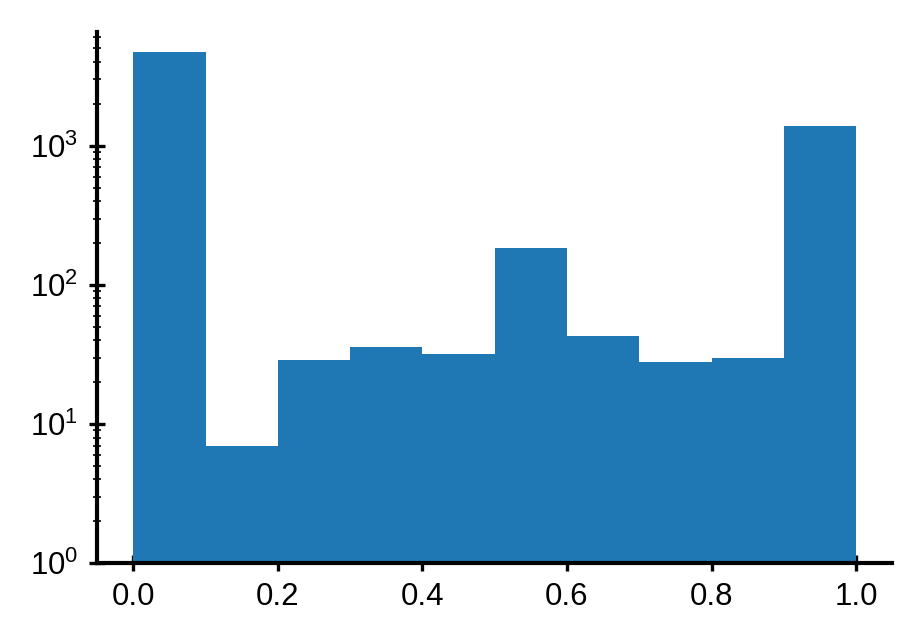

In [12]:
plt.hist(positive_fraction)
plt.yscale('log')
plt.ylim(1e0)

# Keep only unambiguous

In [72]:
d_mean = df_t[[('Epitope', 'Description'),
               ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(np.mean)
d = d_mean[d_mean['Assay', 'Positive'].isin([0.0, 1.0])]
d = d.reset_index()
len(d)

6123

In [73]:
d['nndist'] = d['Epitope', 'Description'].apply(lambda x: nndist_hamming(x, selfset, maxdist=3))

In [74]:
d['nndist_max'] = np.where(d['nndist']>3, 3, d['nndist'])
dagg = d.groupby('nndist_max').agg(['mean', 'count'])['Assay', 'Positive']
ps = np.asarray(list(dagg['mean']))
ns = np.asarray(dagg['count'])
ps, ns

(array([0.02631579, 0.31782946, 0.2593506 , 0.19982969]),
 array([  38,  129, 2433, 3523]))

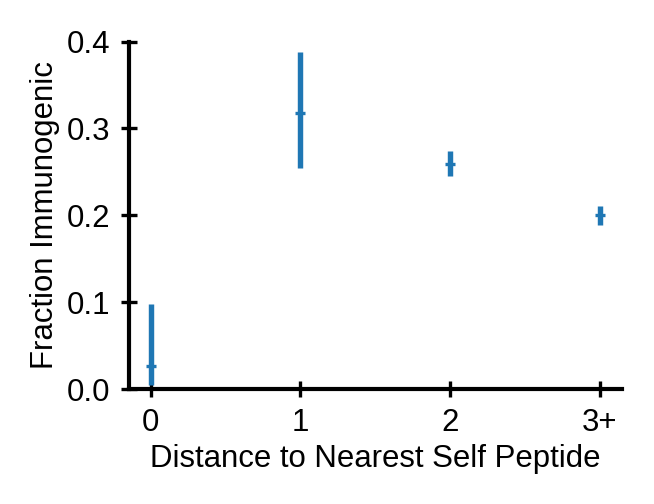

In [79]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
ax.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0.0, 0.4)
ax.set_xlabel('Distance to Nearest Self Peptide')
ax.set_ylabel('Fraction Immunogenic')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, '3+'])
fig.tight_layout()
fig.savefig(figuredir+'iedbposvsdist.svg')

In [78]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((0, 1), 0.0013614379111919206),
 ((0, 2), 0.0043381908640062194),
 ((0, 3), 0.01511727530608753),
 ((1, 2), 0.14117556527930142),
 ((1, 3), 0.0043381908640062194),
 ((2, 3), 3.6857432239578714e-07)]

# Closer look at near matches

In [18]:
df_t[df_t['Epitope', 'Description'].isin(set(d[(d['nndist']==0)
     & d['Assay', 'Positive']]['Epitope', 'Description']))]['Epitope']

,Epitope IRI,Object Type,Description,Starting Position,Ending Position,Non-peptidic epitope IRI,Antigen Name,Antigen IRI,Parent Protein,Parent Protein IRI,Organism Name,Organism IRI,Parent Species,Parent Species IRI,Epitope Comments,Length
322799,http://www.iedb.org/epitope/184390,Linear peptide,LIDGISLGL,1248.0,1256.0,NaN,polyprotein,http://www.ncbi.nlm.nih.gov/protein/ANW72071.1,sp|P17763|POLG_DEN1W Genome polyprotein OS=Den...,http://www.uniprot.org/uniprot/P17763,Dengue virus 4,http://purl.obolibrary.org/obo/NCBITaxon_11070,Dengue virus,http://purl.obolibrary.org/obo/NCBITaxon_12637,NaN,9


In [19]:
df_d1 = d[d['nndist']==1].copy()

In [20]:
epitopes = df_d1['Epitope', 'Description']

In [35]:
alleles = [df_t[df_t['Epitope', 'Description'] == epitope]['MHC', 'Allele Name'].agg(most_frequent)
           for epitope in epitopes]

In [62]:
pd.value_counts(alleles).head(10)

HLA-A*02:01    49
HLA-A*24:02    16
HLA-B*49:01    14
HLA-A*33:03    10
HLA-A*30:02     6
HLA class I     6
HLA-A2          4
HLA-B*07:02     3
HLA-B*44:02     2
HLA-B*53:01     2
dtype: int64

In [109]:
neighbors = []
neighbor_numbers = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(hamming_neighbors(epitope)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    diffpos = int(np.where(np.array(list(epitope)) != np.array(list(neighbor)))[0])
    diffposs.append(diffpos)
    neighbors.append(neighbor)
    neighbor_numbers.append(len(all_neighbors))
    #print(epitope,
    #      neighbor,
    #      len(all_neighbors),
    #      diffpos)
neighbor_numbers = np.array(neighbor_numbers)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

In [103]:
df_d1['Position difference'] = diffposs
df_d1['Neighbors'] = neighbor_numbers>1.0

In [97]:
anchors = [1, 8]
tcem = [0, 2, 3, 4, 5, 6, 7]

/home/andreas/mambaforge/envs/peptidome/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


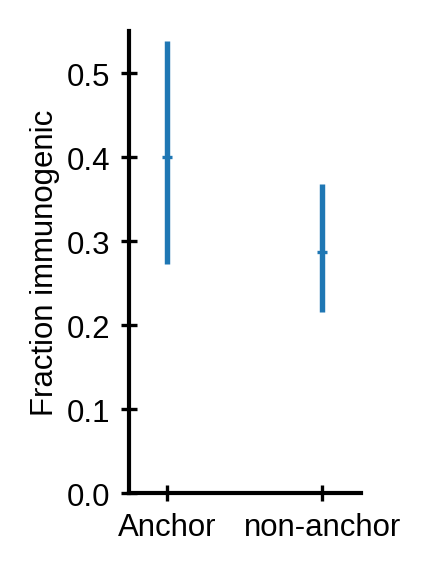

In [98]:
ps = df_d1.groupby('Position difference').agg('mean')['Assay', 'Positive']
ns = df_d1.groupby('Position difference').agg('count')['Assay', 'Positive']
npos = ns*ps
npos_coarse = np.array([npos.loc[anchors].sum(), npos.loc[tcem].sum()])
n_coarse = np.array([ns.loc[anchors].sum(), ns.loc[tcem].sum()])
ps_coarse = npos_coarse/n_coarse
lower, upper = statsmodels.stats.proportion.proportion_confint(npos_coarse, n_coarse, method='jeffreys', alpha=.1)
fig, ax = plt.subplots(figsize=(1.0, 2))
ax.errorbar(['Anchor', 'non-anchor'], ps_coarse, yerr=[ps_coarse-lower, upper-ps_coarse], ls='None', fmt='_')
ax.set_ylim(0, 0.55)
ax.set_xlim(-0.25, 1.25)
ax.set_ylabel('Fraction immunogenic')
fig.savefig('anchor_vs_tcem.svg')

In [99]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(npos_coarse, n_coarse)
list(zip(test.all_pairs, test.pval_corrected()))

[((0, 1), 0.22131789616908637)]

Text(0.5, 0, 'Neighbor number')

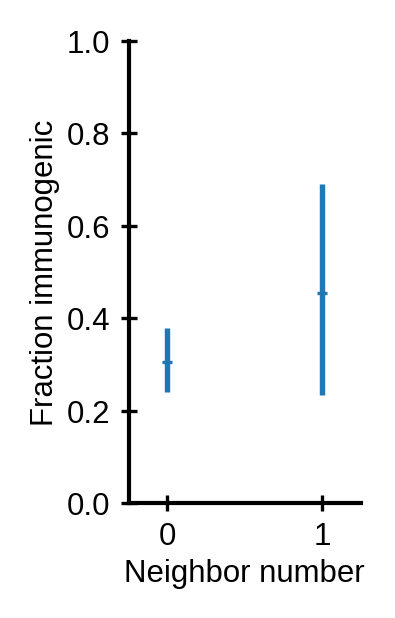

In [104]:
ps = df_d1.groupby('Neighbors').agg('mean')['Assay', 'Positive']
ns = df_d1.groupby('Neighbors').agg('count')['Assay', 'Positive']
npos = ns*ps
lower, upper = statsmodels.stats.proportion.proportion_confint(npos, ns, method='jeffreys', alpha=.1)
fig, ax = plt.subplots(figsize=(1.0, 2))
ax.errorbar(ns.index, ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0, 1.0)
ax.set_xlim(-0.25, 1.25)
ax.set_ylabel('Fraction immunogenic')
ax.set_xlabel('Neighbor number')

# Epitope Distance

In [105]:
sys.path.append('/home/andreas/drop/projects_ongoing/zach_andreas/code/EpitopeDistance/epdist')
from EpitopeDistance import EpitopeDistance

In [90]:
epd = EpitopeDistance()

In [110]:
pairs = list(zip(epitopes, neighbors))

In [112]:
distance = np.array([epd.epitope_dist(epiA, epiB) for epiA, epiB in pairs])

In [113]:
d1 = d[d['nndist']==1]

In [114]:
d1['distance'] = distance

/home/andreas/mambaforge/envs/peptidome/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(MannwhitneyuResult(statistic=1587.0, pvalue=0.13673835793213585),
 Ttest_indResult(statistic=1.1949837651438946, pvalue=0.23432016469218753))

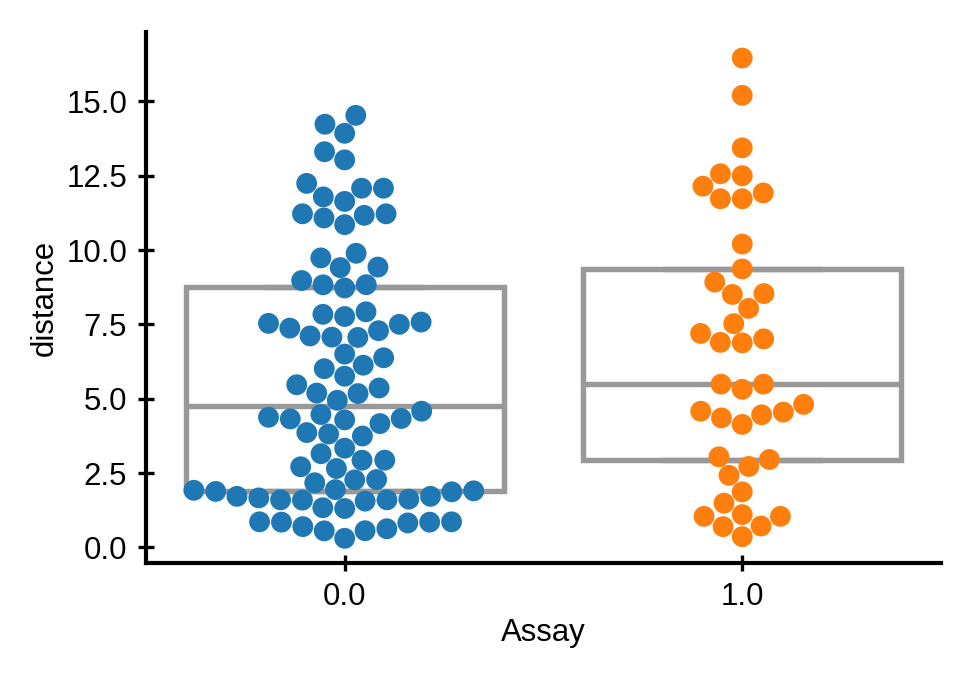

In [206]:
sns.swarmplot(data=d1, x='Assay', y='distance')
sns.boxplot(data=d1, x='Assay', y='distance', color='white', showfliers=False, whis=0)
scipy.stats.mannwhitneyu(d1[d1['Assay']==1.0]['distance'], d1[d1['Assay']==0.0]['distance']), scipy.stats.ttest_ind(d1[d1['Assay']==1.0]['distance'], d1[d1['Assay']==0.0]['distance'])

# Neighbor distance <=2

In [174]:
df_d2 = d[d['nndist']==2].copy()

In [175]:
epitopes = list(df_d2['Epitope', 'Description'])

In [212]:
neighbors = []
neighbor_numbers = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(next_nearest_neighbors(epitope, hamming_neighbors, maxdistance=2)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    diff = np.array(list(epitope)) != np.array(list(neighbor))
    diffpos = list(diff.nonzero()[0])
    diffposs.append(diffpos)
    neighbors.append(neighbor)
    neighbor_numbers.append(len(all_neighbors))
    #print(epitope,
    #      neighbor,
    #      len(all_neighbors),
    #      diffpos)
neighbor_numbers = np.array(neighbor_numbers)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

Text(0.5, 0, 'Frequency')

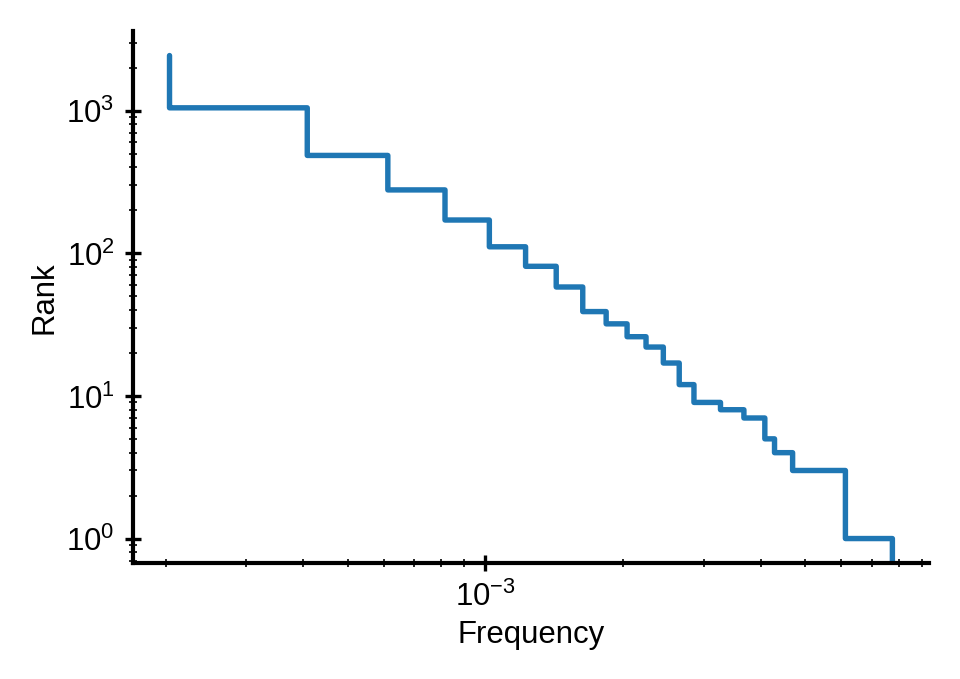

In [237]:
fig, ax = plt.subplots()
pp.rankfrequency(neighbor_numbers, ax=ax)
ax.set_ylabel('Rank')
ax.set_xlabel('Frequency')

In [202]:
df_d2['Anchor'] = np.isin(diffposs[:, 0], anchors).astype(int) + np.isin(diffposs[:, 1], anchors)
df_d2['Neighbors'] = neighbor_numbers>1.0

Anchor
0    0.261953
1    0.249158
2    0.350877
Name: (Assay, Positive), dtype: float64 Anchor
0    1485
1     891
2      57
Name: (Assay, Positive), dtype: int64


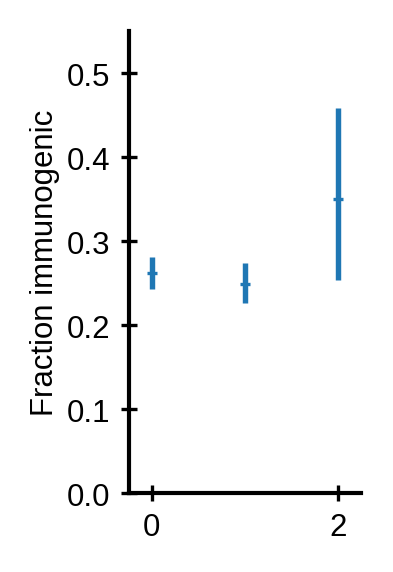

In [205]:
ps = df_d2.groupby('Anchor').agg('mean')['Assay', 'Positive']
ns = df_d2.groupby('Anchor').agg('count')['Assay', 'Positive']
print(ps, ns)
npos = ns*ps
lower, upper = statsmodels.stats.proportion.proportion_confint(npos, ns, method='jeffreys', alpha=.1)
fig, ax = plt.subplots(figsize=(1.0, 2))
ax.errorbar(ps.index, ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0, 0.55)
ax.set_xlim(-0.25, 2.25)
ax.set_ylabel('Fraction immunogenic')
fig.savefig('anchor_vs_tcem_d2.svg')

In [213]:
pairs = list(zip(epitopes, neighbors))

In [214]:
distance = np.array([epd.epitope_dist(epiA, epiB) for epiA, epiB in pairs])

In [225]:
df_d2.columns = df_d2.columns.droplevel(1)

In [226]:
df_d2['distance'] = distance

In [229]:
sns.swarmplot?

(MannwhitneyuResult(statistic=565790.0, pvalue=0.42839782820062633),
 Ttest_indResult(statistic=-0.18134700150555705, pvalue=0.856110333698723))

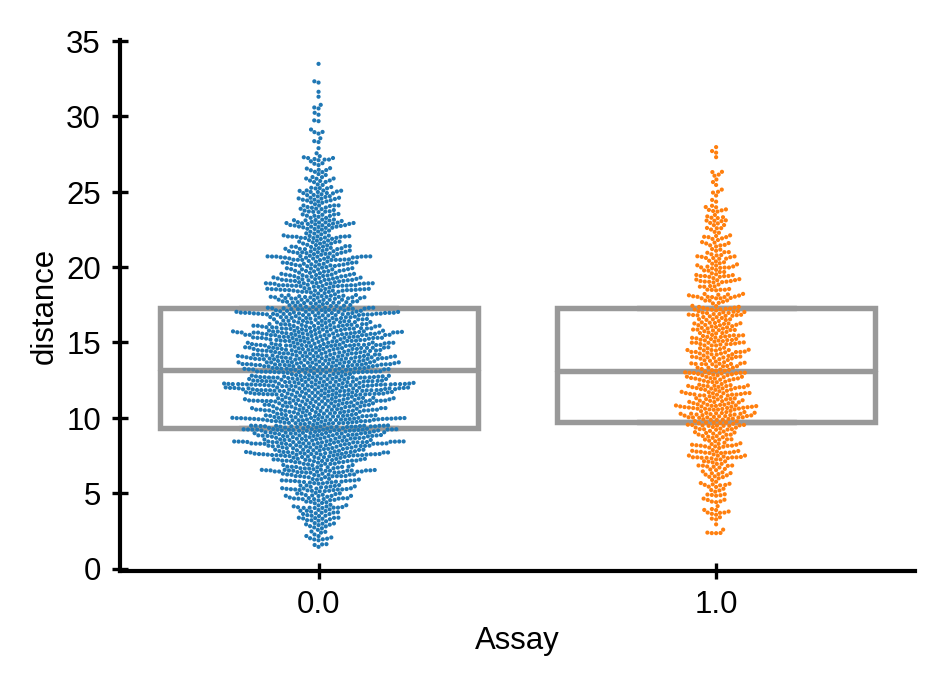

In [230]:
sns.swarmplot(data=df_d2, x='Assay', y='distance', size=1)
sns.boxplot(data=df_d2, x='Assay', y='distance', color='white', showfliers=False, whis=0)
(scipy.stats.mannwhitneyu(df_d2[df_d2['Assay']==1.0]['distance'],
                          df_d2[df_d2['Assay']==0.0]['distance']),
 scipy.stats.ttest_ind(df_d2[df_d2['Assay']==1.0]['distance'],
                       df_d2[df_d2['Assay']==0.0]['distance']))

In [228]:
df_d2

,Epitope,Assay,nndist,nndist_max,Position difference 0,Neighbors,Position difference 1,Anchor,distance
0,AAAGDKLSL,1.0,2,2,4,True,5,0,9.883118
3,AAFSSARFL,1.0,2,2,2,False,7,0,5.208283
4,AAGRKSLTL,1.0,2,2,1,True,5,1,17.234674
5,AAHARFVAA,1.0,2,2,3,True,4,0,24.999449
6,AARDRFPGL,1.0,2,2,1,True,4,1,13.552231
7,AARQRLQDI,1.0,2,2,7,True,8,1,5.551420
8,AAVDLSHFL,0.0,2,2,4,True,6,0,18.438542
9,AAVKAGAAL,1.0,2,2,3,True,4,0,16.145745
13,ADAFILLNY,0.0,2,2,6,False,7,0,4.821250
18,AEEFVQQRL,0.0,2,2,0,True,4,0,16.599150
